# Citibike Trip Data Analysis and Visualization
Exploring and visualizing Citibike trip data with network flow maps


In [11]:
import pandas as pd
import pydeck as pdk
import folium
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import os


## Load and Explore Data


In [12]:
df = pd.read_csv("../202408-citibike-tripdata/202408-citibike-tripdata_1.csv")
print(f"Total trips: {len(df)}")
df.head()


/var/folders/rc/c3x5d8vj7jqf4kwwmqlqb6l40000gn/T/ipykernel_53435/7641703.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../202408-citibike-tripdata/202408-citibike-tripdata_1.csv")


Total trips: 1000000


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB4E29A011E918E,electric_bike,2024-08-13 22:28:13.065,2024-08-13 22:30:43.138,McKibbin St & Bogart St,5059.02,Wilson Ave & Troutman St,4864.09,40.706237,-73.933871,40.701660,-73.927540,member
1,6389E1E171CE17CD,classic_bike,2024-08-07 09:39:52.489,2024-08-07 09:43:14.975,Bialystoker Pl & Delancey St,5335.03,Norfolk St & Broome St,5374.01,40.716226,-73.982612,40.717227,-73.988021,member
2,3F4BBEBDFB7548C0,electric_bike,2024-08-10 21:04:35.143,2024-08-10 21:21:43.846,Rivington St & Chrystie St,5453.01,Kent Ave & Division Ave,5021.05,40.721101,-73.991925,40.706564,-73.968319,member
3,C0939F0CD7ED731E,classic_bike,2024-08-13 19:21:31.275,2024-08-13 19:33:43.790,Broadway & E 21 St,6098.10,1 Ave & E 39 St,6303.01,40.739888,-73.989586,40.747140,-73.971130,member
4,4CB3950095D804D6,electric_bike,2024-08-09 22:23:42.894,2024-08-09 22:58:04.455,E 34 St & Church Ave,3318.05,48 St & 2 Ave,3283.05,40.651160,-73.945770,40.650176,-74.015606,casual


In [13]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name    683
start_station_id      683
end_station_name      248
end_station_id        606
start_lat             683
start_lng             683
end_lat               606
end_lng               606
member_casual           0
dtype: int64
ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name    683
start_station_id      683
end_station_name      248
end_station_id        606
start_lat             683
start_lng             683
end_lat               606
end_lng               606
member_casual           0
dtype: int64


## Basic Trip Analysis


In [14]:
# Parse datetime columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60  # in minutes

print(f"Average trip duration: {df['trip_duration'].mean():.2f} minutes")
print(f"Median trip duration: {df['trip_duration'].median():.2f} minutes")


Average trip duration: 13.90 minutes
Median trip duration: 9.56 minutes


In [15]:
# Bike type distribution
print("Bike type distribution:")
print(df['rideable_type'].value_counts())
print("\nMember vs Casual:")
print(df['member_casual'].value_counts())


Bike type distribution:
rideable_type
electric_bike    666146
classic_bike     333854
Name: count, dtype: int64

Member vs Casual:
member_casual
member    771034
casual    228966
Name: count, dtype: int64


In [16]:
# Most popular stations
print("Top 10 Start Stations:")
print(df['start_station_name'].value_counts().head(10))
print("\nTop 10 End Stations:")
print(df['end_station_name'].value_counts().head(10))


Top 10 Start Stations:
start_station_name
Lafayette St & E 8 St       3645
West St & Chambers St       3443
11 Ave & W 41 St            3199
Broadway & E 14 St          3000
W 31 St & 7 Ave             2998
University Pl & E 14 St     2935
W 21 St & 6 Ave             2920
Broadway & W 58 St          2873
8 Ave & W 31 St             2847
Pier 61 at Chelsea Piers    2828
Name: count, dtype: int64

Top 10 End Stations:
end_station_name
West St & Chambers St            6325
University Pl & E 14 St          5819
Broadway & W 58 St               5428
9 Ave & W 33 St                  5301
1 Ave & E 68 St                  5140
W 30 St & 10 Ave                 5128
6 Ave & W 33 St                  4941
Central Park S & 6 Ave           4704
Christopher St & Greenwich St    4205
Washington St & Gansevoort St    4192
Name: count, dtype: int64


## Aggregate Trips by Station Pairs


In [17]:
# Aggregate by station pairs to count number of trips
df_agg = df.groupby([
    'start_station_name', 'start_station_id', 'start_lat', 'start_lng',
    'end_station_name', 'end_station_id', 'end_lat', 'end_lng'
], as_index=False).size()

df_agg.columns = [
    'start_station_name', 'start_station_id', 'start_lat', 'start_lng',
    'end_station_name', 'end_station_id', 'end_lat', 'end_lng', 'trip_count'
]

print(f"Unique station pairs: {len(df_agg)}")
print("\nTop 10 most popular routes:")
df_agg_sorted = df_agg.sort_values('trip_count', ascending=False)
print(df_agg_sorted[['start_station_name', 'end_station_name', 'trip_count']].head(10))


Unique station pairs: 278356

Top 10 most popular routes:
                start_station_name               end_station_name  trip_count
76761       Central Park S & 6 Ave         Central Park S & 6 Ave         555
66075           Broadway & W 53 St             Broadway & W 51 St         400
278355       Yankee Ferry Terminal          Yankee Ferry Terminal         372
78998      Centre St & Chambers St        Centre St & Chambers St         312
66671           Broadway & W 58 St             Broadway & W 58 St         298
237165        Vesey St & Church St  North Moore St & Greenwich St         289
27611              5 Ave & E 87 St                5 Ave & E 87 St         284
221479            Soissons Landing          Yankee Ferry Terminal         277
35091   7 Ave & Central Park South     7 Ave & Central Park South         260
212737       River Ter & Warren St       Vesey Pl & River Terrace         238


Saved hourly pair summary to outputs/hourly_pair_summary.csv


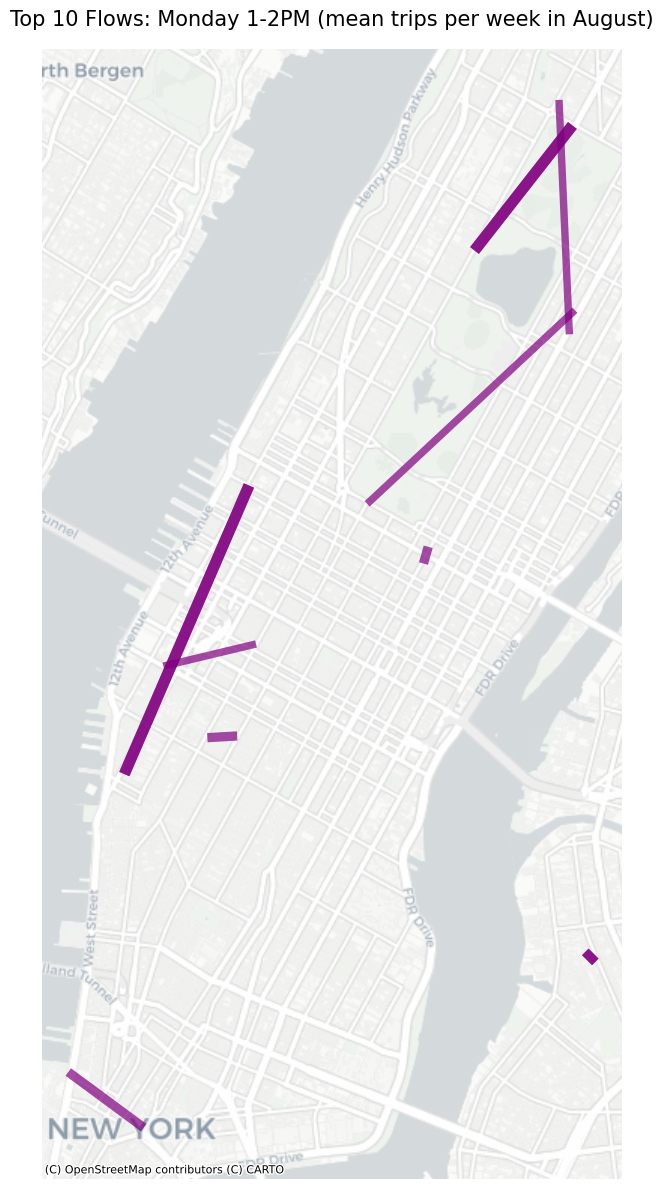

{'start': 'Wilson Ave & Troutman', 'end': 'McKibbin St & Bogart St', 'weekday': 0, 'hour_range': (13, 14), 'mean_trips': 0.0, 'median_trips': 0.0, 'hours_observed': 0}
Hourly/day-of-week aggregation ready. Use avg_trips_between or avg_trips_between_range to query.


In [20]:
# HOURLY + DAY-OF-WEEK AGGREGATION AND QUERY HELPERS",

# Ensure started_at is timezone-aware datetime",
if not pd.api.types.is_datetime64_any_dtype(df['started_at']):
    df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
if df['started_at'].dt.tz is None:
    df['started_at'] = df['started_at'].dt.tz_localize('UTC')

# Extract useful columns: date, weekday, hour
df['date'] = df['started_at'].dt.date
# weekday: Monday=0 .. Sunday=6
df['weekday'] = df['started_at'].dt.weekday
df['hour'] = df['started_at'].dt.hour

# Aggregate counts per day, per hour, per station-pair
hourly_pair = df.groupby(['date', 'weekday', 'hour', 'start_station_name', 'end_station_name']).size().reset_index(name='trip_count')

# For queries across a month by weekday+hour-range, we need to average across matching dates in the month.",
# Example: For all Mondays (weekday=0) in the dataset month, between hour H and H+1, compute mean trips between A and B.",

# Precompute pivot-like structure: group by weekday,hour,start,end and compute mean and count of days contributing",
agg_weekday_hour = hourly_pair.groupby(['weekday', 'hour', 'start_station_name', 'end_station_name']).agg(
    mean_trips=('trip_count', 'mean'),
    median_trips=('trip_count', 'median'),
    days_present=('trip_count', 'count')
).reset_index()

# Save hourly aggregates for inspection
agg_path = 'outputs/hourly_pair_summary.csv'
agg_weekday_hour.to_csv(agg_path, index=False)
print(f'Saved hourly pair summary to {agg_path}')

# Helper function to answer queries
def avg_trips_between(start_name, end_name, weekday, hour):
    mask = (agg_weekday_hour['start_station_name'] == start_name) & (agg_weekday_hour['end_station_name'] == end_name) & (agg_weekday_hour['weekday'] == weekday) & (agg_weekday_hour['hour'] == hour)
    sub = agg_weekday_hour[mask]
    if sub.empty:
        return {'start': start_name, 'end': end_name, 'weekday': weekday, 'hour': hour, 'mean_trips': 0.0, 'median_trips': 0.0, 'days_observed': 0}
    row = sub.iloc[0].to_dict()
    return {'start': start_name, 'end': end_name, 'weekday': weekday, 'hour': hour, 'mean_trips': float(row['mean_trips']), 'median_trips': float(row['median_trips']), 'days_observed': int(row['days_present'])}

# Helper for hour range (e.g., 13 means 13:00-13:59)
def avg_trips_between_range(start_name, end_name, weekday, hour_start, hour_end=None):
    if hour_end is None:
        hour_end = hour_start + 1
    hrs = list(range(hour_start, hour_end))
    
    
    # Choose weekday and hour (e.g., Monday=0, hour=13 for 1-2PM)",
    weekday = 0  # Monday
    hour = 13    
    top_n = 10   

    slot_df = agg_weekday_hour[(agg_weekday_hour['weekday'] == weekday) & (agg_weekday_hour['hour'] == hour)]
    slot_df = slot_df.sort_values('mean_trips', ascending=False).head(top_n)

    # Merge with station coordinates to get lat/lng
    # We'll use the stations DataFrame created earlier (if not, recreate it)
    if 'stations' not in locals():
        stations_start = df[['start_station_name', 'start_station_id', 'start_lat', 'start_lng']].drop_duplicates()
        stations_start.columns = ['station_name', 'station_id', 'lat', 'lng']
        stations_end = df[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']].drop_duplicates()
        stations_end.columns = ['station_name', 'station_id', 'lat', 'lng']
        stations = pd.concat([stations_start, stations_end]).drop_duplicates(subset=['station_id'])

    # Merge to get coordinates for start and end stations
    slot_df = slot_df.merge(stations[['station_name', 'lat', 'lng']], left_on='start_station_name', right_on='station_name', how='left').rename(columns={'lat': 'start_lat', 'lng': 'start_lng'}).drop('station_name', axis=1)
    slot_df = slot_df.merge(stations[['station_name', 'lat', 'lng']], left_on='end_station_name', right_on='station_name', how='left').rename(columns={'lat': 'end_lat', 'lng': 'end_lng'}).drop('station_name', axis=1)

    # Create LineString geometries for each flow
    from shapely.geometry import LineString
    slot_df['geometry'] = slot_df.apply(lambda row: LineString([(row['start_lng'], row['start_lat']), (row['end_lng'], row['end_lat'])]), axis=1)
    gdf_slot = gpd.GeoDataFrame(slot_df, geometry='geometry', crs='EPSG:4326')
    gdf_slot_merc = gdf_slot.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf_slot_merc.plot(ax=ax, linewidth=gdf_slot_merc['mean_trips'] / gdf_slot_merc['mean_trips'].max() * 8, color='purple', alpha=0.7)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(f'Top {top_n} Flows: Monday 1-2PM (mean trips per week in August)', fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    sub = agg_weekday_hour[(agg_weekday_hour['start_station_name'] == start_name) & (agg_weekday_hour['end_station_name'] == end_name) & (agg_weekday_hour['weekday'] == weekday) & (agg_weekday_hour['hour'].isin(hrs))]

    if sub.empty:
        return {'start': start_name, 'end': end_name, 'weekday': weekday, 'hour_range': (hour_start, hour_end), 'mean_trips': 0.0, 'median_trips': 0.0, 'hours_observed': 0}
    # To get the average across days in the month, we need to average per-day counts first then average those. Since agg_weekday_hour.mean_trips is already mean of daily counts per hour over dates, we can sum mean_trips across hours",
    mean_sum = sub['mean_trips'].sum()
    median_sum = sub['median_trips'].sum()
    return {'start': start_name, 'end': end_name, 'weekday': weekday, 'hour_range': (hour_start, hour_end), 'mean_trips': float(mean_sum), 'median_trips': float(median_sum), 'hours_observed': len(sub)}

# Example usage: replace 'Location A'/'Location B' with actual station names and weekday=0 for Monday, hour=13 for 1PM-2PM
res = avg_trips_between_range('Wilson Ave & Troutman', 'McKibbin St & Bogart St', weekday=0, hour_start=13, hour_end=14)
print(res)
print('Hourly/day-of-week aggregation ready. Use avg_trips_between or avg_trips_between_range to query.')

## Create Geographic Visualizations


In [ ]:
# Create LineString geometries for each trip route
def make_line(row):
    return LineString([
        (row['start_lng'], row['start_lat']),
        (row['end_lng'], row['end_lat'])
    ])

gdf = gpd.GeoDataFrame(
    df_agg, 
    geometry=df_agg.apply(make_line, axis=1), 
    crs="EPSG:4326"
)

print(f"GeoDataFrame created with {len(gdf)} routes")


### Flow Map with Basemap


In [ ]:
# Convert to Web Mercator projection for basemap
gdf_merc = gdf.to_crs(epsg=3857)

# Create the flow map
fig, ax = plt.subplots(figsize=(15, 15))

# Plot lines with width proportional to trip count
gdf_merc.plot(
    ax=ax,
    linewidth=gdf_merc['trip_count'] / gdf_merc['trip_count'].max() * 5,
    color='red',
    alpha=0.6
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Citibike Trip Flows", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()
        

### Focus on Popular Routes


In [ ]:
# Visualize only the most popular routes (e.g., top 50%)
threshold = gdf_merc['trip_count'].quantile(0.5)
gdf_popular = gdf_merc[gdf_merc['trip_count'] >= threshold]

fig, ax = plt.subplots(figsize=(15, 15))

gdf_popular.plot(
    ax=ax,
    linewidth=gdf_popular['trip_count'] / gdf_popular['trip_count'].max() * 8,
    color='blue',
    alpha=0.7
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Popular Citibike Routes (Top 50%, n={len(gdf_popular)})", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Station Point Map


In [ ]:
# Create point geometries for stations
stations_start = df[['start_station_name', 'start_station_id', 'start_lat', 'start_lng']].drop_duplicates()
stations_start.columns = ['station_name', 'station_id', 'lat', 'lng']

stations_end = df[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']].drop_duplicates()
stations_end.columns = ['station_name', 'station_id', 'lat', 'lng']

stations = pd.concat([stations_start, stations_end]).drop_duplicates(subset=['station_id'])

# Count trips per station (both starts and ends)
start_counts = df.groupby('start_station_id').size()
end_counts = df.groupby('end_station_id').size()
total_counts = start_counts.add(end_counts, fill_value=0)

stations['total_trips'] = stations['station_id'].map(total_counts)

print(f"Unique stations: {len(stations)}")
stations.head()


In [ ]:
# Create GeoDataFrame for stations
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lng, stations.lat),
    crs="EPSG:4326"
)

stations_gdf_merc = stations_gdf.to_crs(epsg=3857)

# Plot stations
fig, ax = plt.subplots(figsize=(15, 15))

stations_gdf_merc.plot(
    ax=ax,
    markersize=stations_gdf_merc['total_trips'] / stations_gdf_merc['total_trips'].max() * 200,
    color='green',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Citibike Stations (size = trip volume)", fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Interactive Map with PyDeck


In [ ]:
# Prepare data for PyDeck ArcLayer
arc_data = df_agg.copy()

# Create ArcLayer for trip flows
layer = pdk.Layer(
    "ArcLayer",
    data=arc_data,
    get_source_position=["start_lng", "start_lat"],
    get_target_position=["end_lng", "end_lat"],
    get_source_color=[0, 128, 255, 160],
    get_target_color=[255, 0, 128, 160],
    get_width="trip_count",
    width_scale=0.1,
    width_min_pixels=1,
    pickable=True,
    auto_highlight=True,
)

# Set initial view
view_state = pdk.ViewState(
    latitude=df['start_lat'].mean(),
    longitude=df['start_lng'].mean(),
    zoom=11,
    pitch=40,
)

# Create deck
r = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    tooltip={
        "text": "{start_station_name} → {end_station_name}\nTrips: {trip_count}"
    }
)

# Display inline
r.show()


In [ ]:
# Save to HTML file
r.to_html("../citibike_flows.html")
print("Interactive map saved to citibike_flows.html")


## Additional Analysis


In [ ]:
# Trip duration distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['trip_duration'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Trip Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Trip Duration Distribution')
axes[0].grid(True, alpha=0.3)

# Box plot by bike type
df.boxplot(column='trip_duration', by='rideable_type', ax=axes[1])
axes[1].set_xlabel('Bike Type')
axes[1].set_ylabel('Trip Duration (minutes)')
axes[1].set_title('Trip Duration by Bike Type')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [ ]:
# Usage by hour of day
df['hour'] = df['started_at'].dt.hour

hourly_trips = df.groupby('hour').size()

fig, ax = plt.subplots(figsize=(12, 6))
hourly_trips.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
ax.set_title('Citibike Usage by Hour of Day')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Member vs Casual comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trip count
df['member_casual'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_xlabel('User Type')
axes[0].set_ylabel('Number of Trips')
axes[0].set_title('Trips by User Type')
axes[0].grid(True, alpha=0.3, axis='y')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Average trip duration
df.groupby('member_casual')['trip_duration'].mean().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_xlabel('User Type')
axes[1].set_ylabel('Average Trip Duration (minutes)')
axes[1].set_title('Average Trip Duration by User Type')
axes[1].grid(True, alpha=0.3, axis='y')
plt.sca(axes[1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


Weekly summary (first 8 rows):
                 week_start  trip_count  avg_duration  median_duration
0 2024-08-05 00:00:00+00:00      365545     14.027628         9.626117
1 2024-08-12 00:00:00+00:00      474546     13.963746         9.526125
2 2024-08-19 00:00:00+00:00      159909     13.403319         9.524817

Member vs Casual by week (first 8 rows):
member_casual                week_start  casual  member
0             2024-08-05 00:00:00+00:00   88596  276949
1             2024-08-12 00:00:00+00:00  110016  364530
2             2024-08-19 00:00:00+00:00   30354  129555

Member vs Casual by week (first 8 rows):
member_casual                week_start  casual  member
0             2024-08-05 00:00:00+00:00   88596  276949
1             2024-08-12 00:00:00+00:00  110016  364530
2             2024-08-19 00:00:00+00:00   30354  129555

Top 5 routes per week (sample):
                      week_start       start_station_name  \
42798  2024-08-05 00:00:00+00:00   Central Park S & 6 Ave  

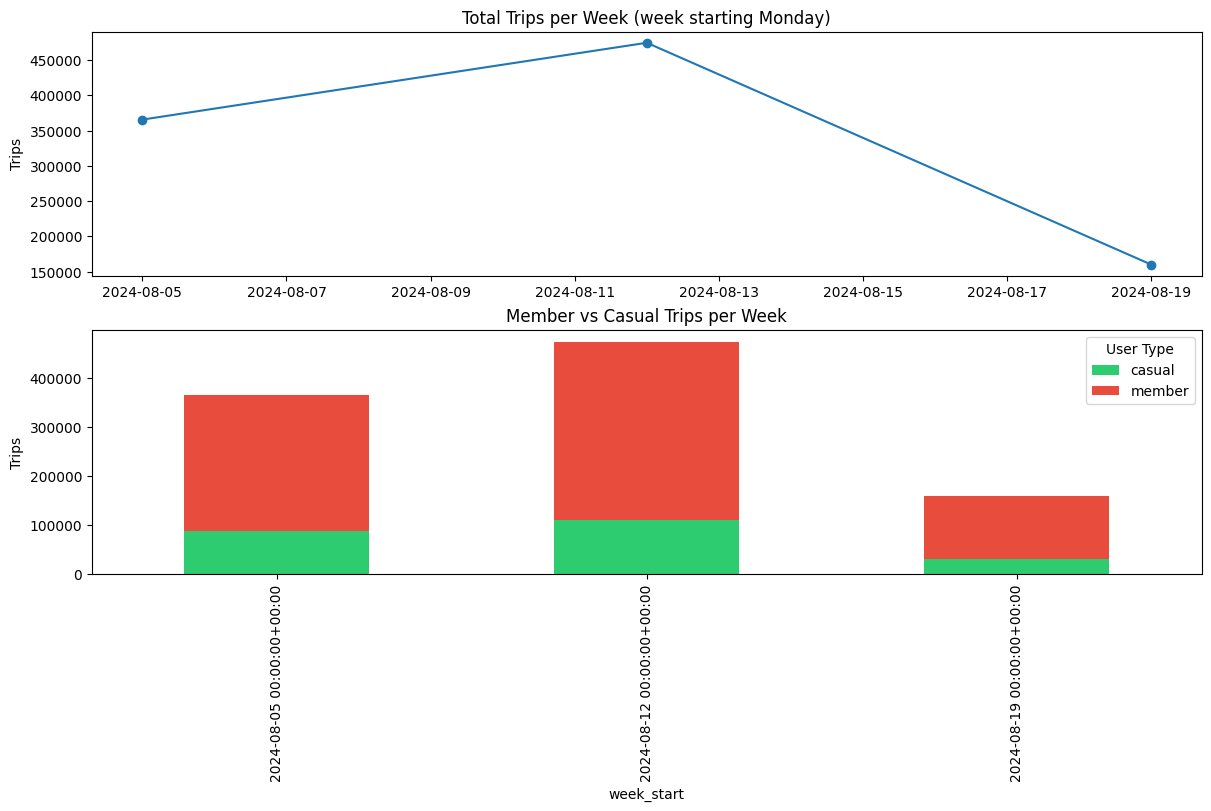


Saved weekly summary to ../outputs/weekly_summary.csv (create outputs/ if missing)


In [10]:
# Ensure started_at is datetime
if not pd.api.types.is_datetime64_any_dtype(df['started_at']):
    df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')

# If naive datetimes, optionally localize (assume UTC here) - adjust as needed
if df['started_at'].dt.tz is None:
    # comment out the next line if your datetimes already have correct timezone
    df['started_at'] = df['started_at'].dt.tz_localize('UTC')

# 1) Week start aggregation using weekly periods starting on Monday
weekly = df.groupby(pd.Grouper(key='started_at', freq='W-MON')).agg(
    trip_count=('rideable_type', 'size'),
    avg_duration=('trip_duration', 'mean'),
    median_duration=('trip_duration', 'median')
).reset_index().rename(columns={'started_at': 'week_start'})

print('Weekly summary (first 8 rows):')
print(weekly.head(8))

# 2) Member vs Casual per week (wide format)
weekly_by_type = df.groupby([pd.Grouper(key='started_at', freq='W-MON'), 'member_casual']).size().unstack(fill_value=0).reset_index().rename(columns={'started_at': 'week_start'})
print('\nMember vs Casual by week (first 8 rows):')
print(weekly_by_type.head(8))

# 3) Top routes per week (top 5 per week)
route_week = df.groupby([pd.Grouper(key='started_at', freq='W-MON'), 'start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
route_week = route_week.sort_values(['started_at', 'trip_count'], ascending=[True, False])
top_routes_per_week = route_week.groupby('started_at').head(5).rename(columns={'started_at': 'week_start'})
print('\nTop 5 routes per week (sample):')
print(top_routes_per_week.head(10))

# 4) Plots: total trips per week and stacked member/casual
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

axes[0].plot(weekly['week_start'], weekly['trip_count'], marker='o')
axes[0].set_title('Total Trips per Week (week starting Monday)')
axes[0].set_ylabel('Trips')

weekly_by_type_plot = weekly_by_type.set_index('week_start')
weekly_by_type_plot.plot(kind='bar', stacked=True, ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Member vs Casual Trips per Week')
axes[1].set_ylabel('Trips')
axes[1].legend(title='User Type')

plt.show()

# 5) Optional: save weekly summary
if not os.path.exists("outputs"):
    os.makedirs("outputs")

weekly.to_csv('outputs/weekly_summary.csv', index=False)
print('\nSaved weekly summary to ../outputs/weekly_summary.csv (create outputs/ if missing)')
